## Necessary Imports

In [1]:
import numpy as np
import scipy
import cmocean
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import spym

## Load data and calculate gap width and gap centers 

In [2]:
def remove_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [3]:
file = spym.load(r'C:\Users\spmuser\OneDrive - USNH\Hollen Lab\Data\LEWIS\20201015 - TaS2 9K slow cool\STM_TaS2_9K_2020_10_18_16_54_32_900.sm4')

ldos = file.LIA_Current
ldos_coords = zip(ldos.RHK_SpecDrift_Xcoord, ldos.RHK_SpecDrift_Ycoord)
ldos_coords = remove_duplicates(ldos_coords)

xsize = ldos.RHK_Xsize
total = ldos.RHK_Ysize
N = len(ldos_coords)
repetitions = total//N

x = ldos.LIA_Current_x.data
ldos_ave = np.array([np.zeros(xsize) for _ in range(N)])

for i in range(N):
    for j in range(repetitions):
        ldos_ave[i] += ldos.data.transpose()[i*repetitions+j]
    ldos_ave[i] /= repetitions

ldos_mean = np.mean(ldos_ave, axis=0)
ldos_variance = np.std(ldos_ave, axis=0)
ldos_max = np.max(ldos_ave, axis=0)
ldos_min = np.min(ldos_ave, axis=0)

gap_shifts = np.zeros(N)
gap_bounds = []

for (i,dIdV) in enumerate(ldos_ave):
    gap_y_tolerance = 2.5e-13 # This should be the error on the average voltage measurements

    gap_x = np.flip([x*1e3 if abs(y) < gap_y_tolerance else None for (x, y) in zip(x, dIdV)])
    gap_x = list(filter(lambda x: x is not None, gap_x))
    if len(gap_x) > 5:
        gap_bounds.append((gap_x[0], gap_x[-1]))
        gap_shifts[i] = gap_x[-1] - gap_x[0]
    else:
        gap_bounds.append((0,0))

## Plotting

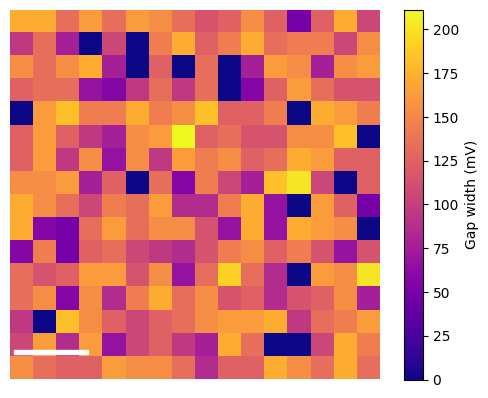

In [13]:
n = int(np.sqrt(N))
assert n**2 == N
gap_shifts = np.reshape(gap_shifts, (n,n))

plt.imshow(gap_shifts, extent=[0,100,0,100], cmap='plasma')
plt.gca().axis('off')
plt.colorbar(label="Gap width (mV)")

fontprops = fm.FontProperties(size=14)
scalebar = AnchoredSizeBar(plt.gca().transData,
                           20, '', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           offset=1,
                           fontproperties=fontprops)

plt.gca().add_artist(scalebar)

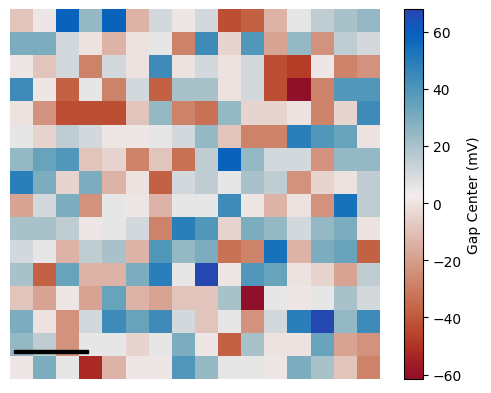

In [14]:
gap_centers = list(map(np.mean, gap_bounds))

n = int(np.sqrt(N))
assert n**2 == N
gap_centers = np.reshape(gap_centers, (n,n))

cmap = cmocean.tools.crop_by_percent(cmocean.cm.balance_r, 25, which='both', N=None)

plt.imshow(gap_centers, extent=[0,100,0,100], cmap=cmap)
plt.gca().axis('off')
plt.colorbar(label="Gap Center (mV)")

fontprops = fm.FontProperties(size=14)
scalebar = AnchoredSizeBar(plt.gca().transData,
                           20, '', 'lower left', 
                           pad=0.1,
                           color='k',
                           frameon=False,
                           size_vertical=1,
                           offset=1,
                           fontproperties=fontprops)

plt.gca().add_artist(scalebar)

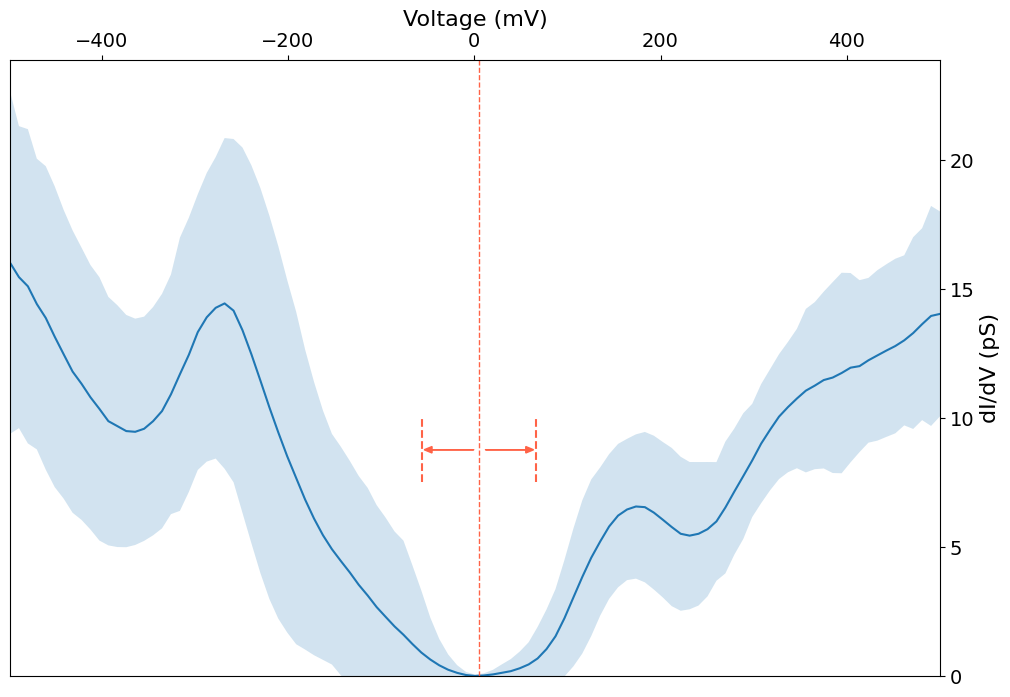

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x*1000, ldos_mean*1e12)
ax.fill_between(x*1000, (ldos_mean - ldos_variance)*1e12, (ldos_mean + ldos_variance)*1e12, alpha=0.2)

ax.set_xlim(x[-1]*1000, x[0]*1000)
ax.set_ylabel('dI/dV (pS)', fontsize=16)
ax.set_xlabel('Voltage (mV)', fontsize=16)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
# ax.set_yticklabels([])
# ax.tick_params(axis='y', color='white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

center_mean = np.mean(gap_centers)
width_mean = np.mean(gap_shifts)
center_std = np.std(gap_centers)
width_std = np.std(gap_shifts)
ax.axvline(center_mean, lw=1, ls='--', c='tomato')

gap_low = center_mean - width_mean/2
gap_high = center_mean + width_mean/2
ax.plot([gap_low, gap_low], [7.5, 10], ls='--', c='tomato')
ax.plot([gap_high, gap_high], [7.5, 10], ls='--', c='tomato')
ax.arrow(center_mean+gap_high*0.1, (17.5)/2, gap_high*0.65, 0, head_length=abs(gap_low)*0.15, head_width=0.25, facecolor='tomato', edgecolor='tomato')
ax.arrow(center_mean+gap_low*0.1, (17.5)/2, gap_low*0.8, 0, head_length=abs(gap_low)*0.15, head_width=0.25, facecolor='tomato', edgecolor='tomato')
# ax.axvspan(center_mean - width_mean/2, center_mean + width_mean/2, alpha=0.2, color='tomato')
ax.set_ybound(lower=0)

## Stats

In [10]:
center_mean = np.mean(np.abs(gap_centers))
width_mean = np.mean(np.abs(gap_shifts))
center_std =  np.std(np.abs(gap_centers))
width_std =   np.std(np.abs(gap_shifts))

print(f'Gap width = {width_mean} +/- {width_std}')
print(f'Gap center = {center_mean} +/- {center_std}')

Gap width = 122.91827997250948 +/- 46.319000228164995
Gap center = 20.127928764850367 +/- 15.74230398384493
